In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB6


import sklearn
from sklearn.metrics import accuracy_score

print(tf.__version__)


2.17.0


In [ ]:
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_val.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualization of the dataset

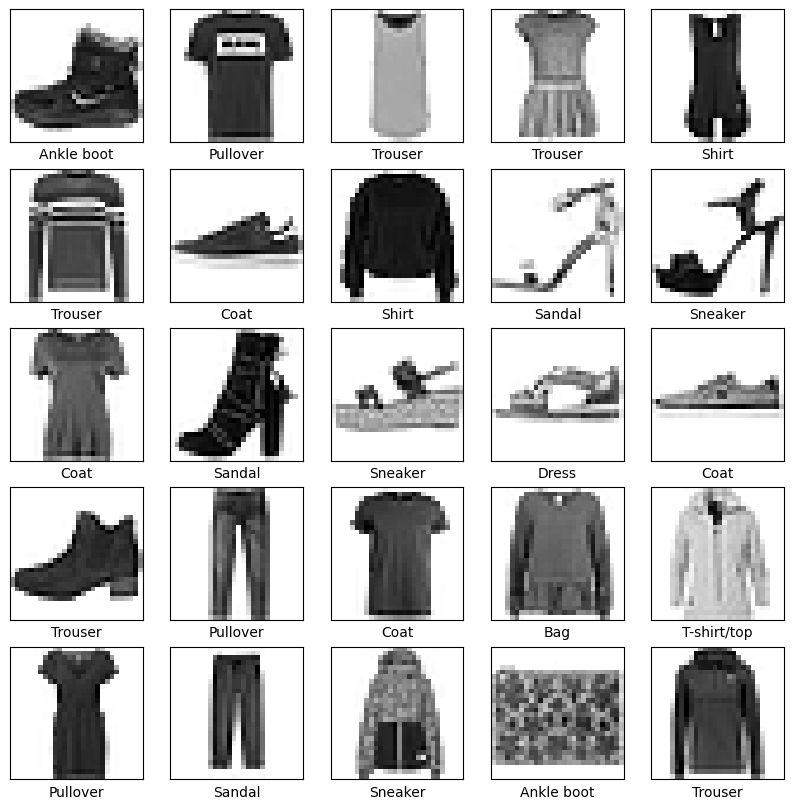

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_val[i]])
plt.show()

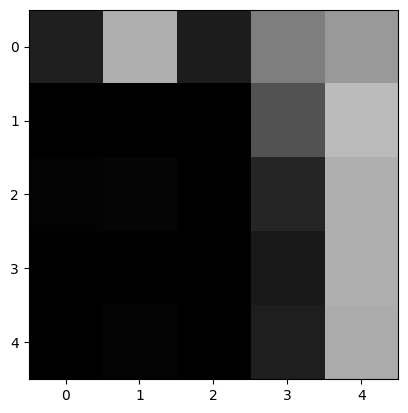

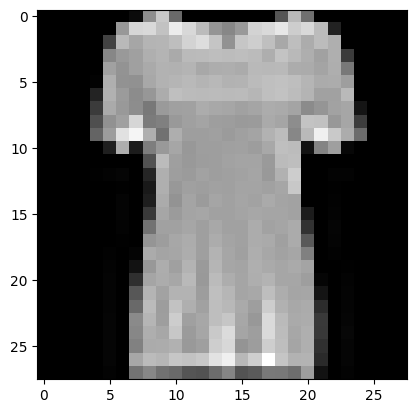

In [ ]:
x_train_image = np.tile(x_train[10, :, :].reshape((28,28))[:, :, np.newaxis], (1, 1, 3))

plt.imshow(x_train_image[10:15, 5:10])
plt.show()

plt.imshow(x_train_image)
plt.show()



Предобработка

In [ ]:
x_train_255 = x_train.astype('float32') / 255.0 - 0.5
x_val_255 = x_val.astype('float32') / 255.0 - 0.5

x_train_a = x_train_255.reshape((x_train_255.shape[0], 28, 28, 1))
x_val_a = x_val_255.reshape((x_val_255.shape[0], 28, 28, 1))

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

In [ ]:
print(y_train_oh.shape)

(60000, 10)


In [ ]:
print(y_train_oh[:3], y_train[:3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0]


In [ ]:
print(x_train_a.shape)
print(x_val_a.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In preprocessing, we normalize the pixel values. We shift the range to the range from -0.5 to 0.5 to make the values more symmetrical relative to zero. We change the shape of the data to match the expected format of the input data of the neural network.  One-Hot Encoding for class labels. This is necessary so that class labels are represented as vectors, where each class has its own element in the vector.

Creating a simple model, without additional layers of regularization 

In [ ]:
K.clear_session()

model1 = M.Sequential()

model1.add(L.Conv2D(3, kernel_size=3, strides=1, activation= 'relu', padding = 'same', input_shape=(28,28,1)))
model1.add(L.Conv2D(32, kernel_size=3, strides=1, activation= 'relu'))
model1.add(L.Conv2D(64, kernel_size=3, strides=1, activation= 'relu'))
model1.add(L.Flatten())
model1.add(L.Dense(64, activation= 'relu'))
model1.add(L.Dense(32, activation= 'relu'))
model1.add(L.Dense(10, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,359,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,381,192 (9.08 MB)

 Trainable params: 2,381,192 (9.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
history1 = model1.fit(
    x_train_a,
    y_train_oh,
    batch_size = 32,
    epochs = 10,
    validation_data = (x_val_a, y_val_oh)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7832 - loss: 0.6034 - val_accuracy: 0.8708 - val_loss: 0.3483
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9067 - loss: 0.2552 - val_accuracy: 0.9069 - val_loss: 0.2652
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9331 - loss: 0.1780 - val_accuracy: 0.8994 - val_loss: 0.2905
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9576 - loss: 0.1162 - val_accuracy: 0.9055 - val_loss: 0.2858
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9732 - loss: 0.0736 - val_accuracy: 0.9090 - val_loss: 0.3341
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9825 - loss: 0.0467 - val_accuracy: 0.9077 - val_loss: 0.3853
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9902 - loss: 0.0290 - val_accuracy: 0.9048 - val_loss: 0.4654
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9902 - loss: 0.02

In [ ]:
model1.evaluate(x_val_a, y_val_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.5563


[0.559664249420166, 0.9057999849319458]

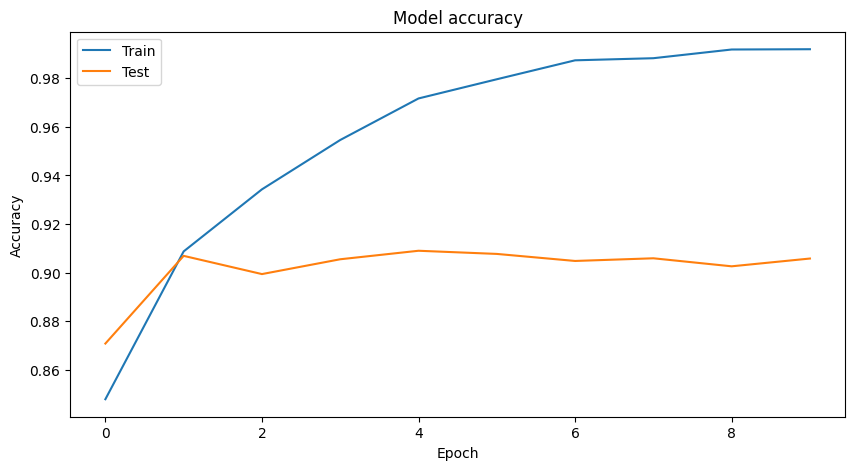

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

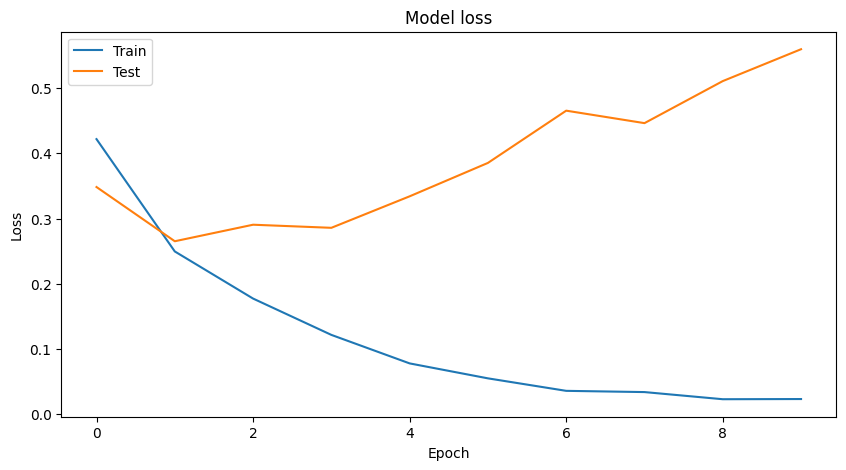

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Judging by the graphs, this model has been retrained, because the indicators of the training and validation samples are very different. The loss of the validation sample is also increasing.

Вторая модель. Усложним модель добавив слои регуляризации и дополнительные слои обучения.

In [ ]:
K.clear_session()

model2 = M.Sequential()

model2.add(L.Conv2D(32, kernel_size=3, strides=1, activation= 'relu', padding = 'same', input_shape=(28,28,1)))
model2.add(L.MaxPooling2D((2,2)))

model2.add(L.Conv2D(64, kernel_size=3, strides=1, activation= 'relu'))
model2.add(L.MaxPooling2D((2,2)))
model2.add(L.Dropout(0.2))

model2.add(L.Conv2D(128, kernel_size=3, strides=1, activation= 'relu'))
model2.add(L.MaxPooling2D((2,2)))
model2.add(L.Dropout(0.2))

model2.add(L.Flatten())

model2.add(L.Dense(128, activation= 'relu'))
model2.add(L.Dropout(0.2))

model2.add(L.Dense(64, activation= 'relu'))
model2.add(L.Dropout(0.2))

model2.add(L.Dense(10, activation='softmax'))






/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,242 (653.29 KB)

 Trainable params: 167,242 (653.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
history2 = model2.fit(
    x_train_a,
    y_train_oh,
    batch_size = 32,
    epochs = 10,
    validation_data = (x_val_a, y_val_oh)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6874 - loss: 0.8493 - val_accuracy: 0.8615 - val_loss: 0.3878
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8650 - loss: 0.3824 - val_accuracy: 0.8869 - val_loss: 0.3104
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8843 - loss: 0.3233 - val_accuracy: 0.8999 - val_loss: 0.2704
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8953 - loss: 0.2916 - val_accuracy: 0.8973 - val_loss: 0.2685
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9021 - loss: 0.2733 - val_accuracy: 0.9017 - val_loss: 0.2760
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9101 - loss: 0.2513 - val_accuracy: 0.9101 - val_loss: 0.2480
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9134 - loss: 0.2416 - val_accuracy: 0.9135 - val_loss: 0.2370
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9168 - loss: 0.228

In [ ]:
model2.evaluate(x_val_a, y_val_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.2561


[0.24679286777973175, 0.9110000133514404]

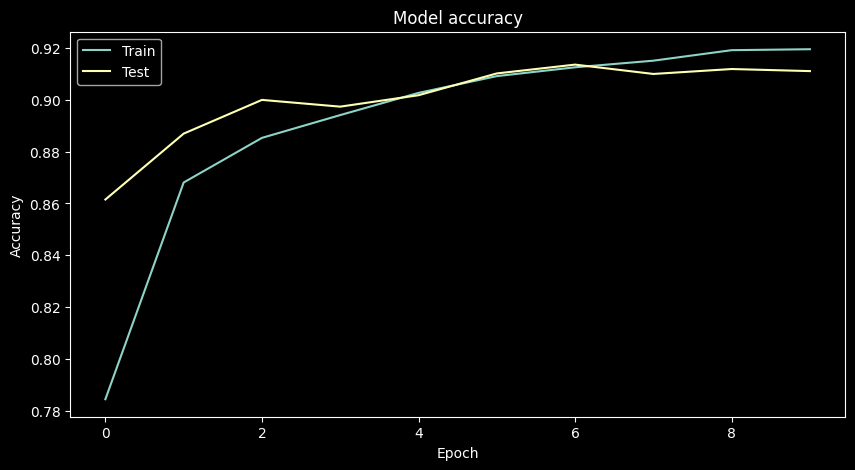

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

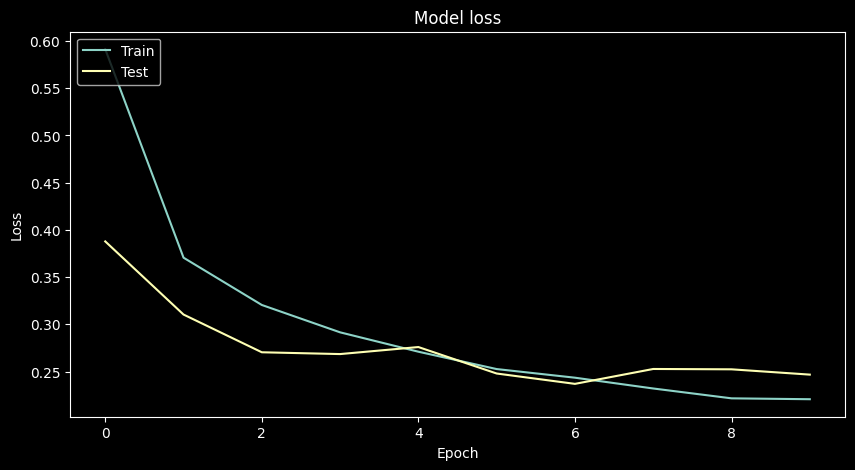

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

The results shown by the second model are more favorable. The retraining of the model was noticeably reduced, and validation losses also decreased

Conclusion: the second model is less prone to retraining, as can be seen on the graph. These indicators were achieved by changing the number of filters, adding: Dropout, MaxPooling2D. I also used BatchNormalization, but there were no results of increasing the metrics.